# import DHM200

In [46]:
file = open('src/data/DHM200/DHM200.asc', 'r')
lines = file.readlines()

In [47]:
n_head_lines = 6

In [1]:
import numpy as np
import pandas as pd
import pyvista as pv
from shapely.geometry import Point, Polygon

In [49]:
header = lines[:n_head_lines]
data = [line.strip().split(" ") for line in lines[n_head_lines:]]
flat = []
for line in data:
    flat += line
flat = list(map(float, flat))

In [50]:
meta = {head.split(" ")[0].lower():float(head.split(" ")[1].strip()) for head in header}
for key, value in meta.items():
    if int(value)==value:
        meta[key] = int(value)

In [51]:
meta

{'ncols': 1926,
 'nrows': 1201,
 'xllcorner': 479900,
 'yllcorner': 61900,
 'cellsize': 200,
 'nodata_value': -9999}

evaluate data

In [52]:
if len(flat)/meta["nrows"]==meta["ncols"]:
    print("passed")
else:
    print("failed:", len(flat)/meta["nrows"],"not",meta["ncols"])

passed


In [53]:
chunks = [flat[x:x+meta["ncols"]] for x in range(0, len(flat), meta["ncols"])]

In [54]:
x = np.ones(meta["ncols"]).cumsum()
x -= 1 
x *= meta["cellsize"]
x += meta["xllcorner"]
x

array([479900., 480100., 480300., ..., 864500., 864700., 864900.])

In [55]:
y = np.ones(meta["nrows"]).cumsum()
y -= 1
y *= meta["cellsize"]
y += meta["yllcorner"]
y = np.flip(y)
y

array([301900., 301700., 301500., ...,  62300.,  62100.,  61900.])

In [56]:
swiss = pd.DataFrame(chunks, columns=x, index=y)
swiss.replace(meta["nodata_value"], np.nan, inplace=True)
print("shape:",swiss.shape)
swiss

shape: (1201, 1926)


,479900.0,480100.0,480300.0,480500.0,480700.0,480900.0,481100.0,481300.0,481500.0,481700.0,...,863100.0,863300.0,863500.0,863700.0,863900.0,864100.0,864300.0,864500.0,864700.0,864900.0
301900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
import pickle

In [58]:
with open('src/cache/dhm_200.pkl', 'wb') as file:  # open a text file
    pickle.dump(swiss, file) # serialize the list

## Filter bounds

In [59]:
last_active_drawings = {
  "type": "Feature",
  "properties": {},
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          9.041576,
          47.128432
        ],
        [
          9.041576,
          47.171394
        ],
        [
          9.325848,
          47.171394
        ],
        [
          9.325848,
          47.128432
        ],
        [
          9.041576,
          47.128432
        ]
      ]
    ]
  }
}

In [60]:
def coords2LV03(lat, lng, **kwargs):
    #Breite φ und die Länge λ. https://de.wikipedia.org/wiki/Schweizer_Landeskoordinaten
    φ = lat*3600
    λ = lng*3600

    #Berechnung der Hilfsgrössen:
    φ_ = (φ - 169028.66) / 10000
    λ_ = (λ - 26782.5) / 10000

    #Berechnung der Meterkoordinaten:
    y = round(200147.07 + 308807.95*φ_ + 3745.25*λ_**2 + 76.63*φ_**2 + 119.79*φ_**3 - 194.56*λ_**2*φ_)
    x = round(600072.37 + 211455.93*λ_ - 10938.51*λ_*φ_ - 0.36*λ_*φ_**2 - 44.54*λ_**3)
    return x,y

def coords2LV95(lat, lng, **kwargs):
    #Breite φ und die Länge λ. https://de.wikipedia.org/wiki/Schweizer_Landeskoordinaten
    #Achtung nicht genau gleich!
    φ = lat*3600
    λ = lng*3600

    #Berechnung der Hilfsgrössen:
    φ_ = (φ - 169028.66) / 10000
    λ_ = (λ - 26782.5) / 10000

    #Berechnung der Meterkoordinaten:
    y = round(200147.07 + 308807.95*φ_ + 3745.25*λ_**2 + 76.63*φ_**2 + 119.79*φ_**3 - 194.56*λ_**2*φ_)+1000000
    x = round(600072.37 + 211455.93*λ_ - 10938.51*λ_*φ_ - 0.36*λ_*φ_**2 - 44.54*λ_**3)+2000000
    return x,y

In [61]:
points = last_active_drawings["geometry"]["coordinates"][0]
poly = Polygon(points)

bounds_sw = poly.bounds[:2]
bounds_ne = poly.bounds[2:]

x_min, y_min = coords2LV03(bounds_sw[1], bounds_sw[0])
x_max, y_max = coords2LV03(bounds_ne[1], bounds_ne[0])
print("columns:",x_min,"-", x_max)
print("indexes:",y_min,"-", y_max)


columns: 721614 - 743063
indexes: 220958 - 226213


In [62]:
swiss

,479900.0,480100.0,480300.0,480500.0,480700.0,480900.0,481100.0,481300.0,481500.0,481700.0,...,863100.0,863300.0,863500.0,863700.0,863900.0,864100.0,864300.0,864500.0,864700.0,864900.0
301900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
swiss.loc[228229:222182, 721704:733880]

,721900.0,722100.0,722300.0,722500.0,722700.0,722900.0,723100.0,723300.0,723500.0,723700.0,...,731900.0,732100.0,732300.0,732500.0,732700.0,732900.0,733100.0,733300.0,733500.0,733700.0
228100.0,456.489,487.704,505.604,509.190,565.001,691.097,751.706,810.101,812.289,877.696,...,958.988,966.312,975.115,982.911,990.393,1022.207,1048.614,1105.011,1314.505,1339.591
227900.0,443.888,453.405,467.694,482.009,579.606,687.010,703.909,726.687,814.793,884.788,...,1031.795,1046.602,1047.608,1049.305,1015.385,1103.313,1133.398,1302.087,1422.993,1352.512
227700.0,434.608,440.091,449.108,480.612,586.197,638.106,690.912,780.389,863.908,930.291,...,1111.393,1115.008,1118.089,1126.514,1092.499,1168.984,1236.888,1359.994,1593.694,1422.396
227500.0,430.601,438.299,451.797,484.408,519.392,613.799,701.009,784.107,858.504,888.004,...,1192.594,1184.891,1194.700,1122.112,1138.491,1231.795,1356.693,1543.804,1574.486,1370.808
227300.0,432.103,439.511,454.908,474.996,542.302,586.698,667.212,742.189,812.394,833.090,...,1275.901,1268.796,1184.389,1144.495,1199.698,1313.813,1445.910,1558.485,1473.700,1324.187
227100.0,435.610,440.909,449.609,463.212,501.307,565.291,613.589,708.602,742.901,782.709,...,1330.286,1281.685,1197.686,1206.111,1273.700,1343.709,1461.911,1497.906,1391.305,1294.511
226900.0,429.309,436.611,445.891,463.107,489.391,529.595,583.587,615.592,706.994,763.701,...,1352.606,1284.514,1196.995,1242.609,1298.598,1427.708,1516.894,1411.707,1367.696,1303.313
226700.0,427.595,434.608,441.805,456.199,494.400,562.312,611.611,691.492,706.888,744.904,...,1301.804,1247.608,1233.304,1285.615,1384.703,1456.410,1480.396,1413.688,1345.313,1290.487
226500.0,426.804,428.808,429.810,440.197,489.997,570.590,659.303,694.313,732.408,785.003,...,1315.102,1354.115,1329.406,1289.104,1359.994,1424.690,1459.208,1388.004,1347.608,1358.988
226300.0,423.298,426.092,424.089,455.909,488.705,549.789,629.406,653.107,712.398,807.095,...,1523.307,1529.815,1362.509,1375.901,1382.188,1497.592,1535.599,1473.386,1398.912,1394.197


In [64]:
#loc bounds with additional cellsize to include all necessary points 
df = swiss.loc[y_max+meta["cellsize"]:y_min , x_min:x_max+meta["cellsize"]]
print("shape:",df.shape)
df

shape: (27, 108)


,721700.0,721900.0,722100.0,722300.0,722500.0,722700.0,722900.0,723100.0,723300.0,723500.0,...,741300.0,741500.0,741700.0,741900.0,742100.0,742300.0,742500.0,742700.0,742900.0,743100.0
226300.0,420.293,423.298,426.092,424.089,455.909,488.705,549.789,629.406,653.107,712.398,...,1495.486,1478.887,1515.197,1620.415,1672.003,1745.785,1778.189,1624.189,1611.587,1617.286
226100.0,416.892,420.003,421.611,421.795,429.493,446.287,513.408,561.205,639.899,729.007,...,1554.901,1533.115,1584.514,1665.715,1714.285,1814.411,1847.911,1764.610,1682.513,1663.788
225900.0,416.496,418.394,419.001,423.087,429.493,449.002,474.996,544.411,658.090,762.805,...,1620.415,1577.913,1647.105,1674.706,1746.696,1878.196,1906.984,1891.385,1732.696,1709.412
225700.0,416.312,416.997,418.394,420.503,428.492,450.109,492.396,552.795,638.001,720.492,...,1673.103,1616.391,1713.185,1727.394,1758.705,1932.990,1961.791,1872.888,1767.313,1737.809
225500.0,414.704,416.602,418.790,424.300,437.191,472.887,514.199,589.387,669.110,769.712,...,1710.198,1676.907,1741.603,1749.714,1851.915,1995.706,2010.606,1889.985,1784.800,1791.606
225300.0,414.704,415.705,417.393,423.799,446.208,480.401,537.688,590.890,684.506,753.209,...,1767.885,1737.485,1779.988,1779.296,1951.789,2052.198,2041.510,2018.486,1824.888,1818.603
225100.0,414.598,414.809,415.600,422.507,458.098,504.998,549.789,599.510,682.107,784.607,...,1924.188,1798.001,1809.790,1842.295,2016.391,2102.905,2086.710,1958.502,1893.795,1838.402
224900.0,414.704,414.994,417.103,428.202,484.092,490.604,557.303,628.009,715.193,875.113,...,1986.715,2026.388,1838.208,1826.514,2102.685,2163.295,2135.297,1955.408,1910.306,1871.586
224700.0,417.603,418.289,425.196,444.310,449.688,493.899,570.511,577.998,688.408,848.301,...,2053.298,2148.300,1895.706,1967.004,2134.907,2196.901,2142.201,1990.904,1921.703,1878.099
224500.0,417.287,422.006,425.302,430.996,446.788,487.097,510.297,598.087,754.211,918.296,...,2164.992,2226.986,2009.601,2027.803,2222.993,2204.697,2057.206,1996.603,1972.407,1958.990


## Create Surface

In [65]:
x = np.ones(df.shape)
y = x.copy()

In [66]:
x *= np.array(df.columns)
x

array([[721700., 721900., 722100., ..., 742700., 742900., 743100.],
       [721700., 721900., 722100., ..., 742700., 742900., 743100.],
       [721700., 721900., 722100., ..., 742700., 742900., 743100.],
       ...,
       [721700., 721900., 722100., ..., 742700., 742900., 743100.],
       [721700., 721900., 722100., ..., 742700., 742900., 743100.],
       [721700., 721900., 722100., ..., 742700., 742900., 743100.]])

In [67]:
y = (y.T*np.array(df.index)).T
y

array([[226300., 226300., 226300., ..., 226300., 226300., 226300.],
       [226100., 226100., 226100., ..., 226100., 226100., 226100.],
       [225900., 225900., 225900., ..., 225900., 225900., 225900.],
       ...,
       [221500., 221500., 221500., ..., 221500., 221500., 221500.],
       [221300., 221300., 221300., ..., 221300., 221300., 221300.],
       [221100., 221100., 221100., ..., 221100., 221100., 221100.]])

In [68]:
z = np.array(df)
z

array([[ 420.293,  423.298,  426.092, ..., 1624.189, 1611.587, 1617.286],
       [ 416.892,  420.003,  421.611, ..., 1764.61 , 1682.513, 1663.788],
       [ 416.496,  418.394,  419.001, ..., 1891.385, 1732.696, 1709.412],
       ...,
       [ 423.588,  423.509,  422.692, ...,  625.584,  593.703,  716.505],
       [ 445.812,  424.59 ,  423.509, ...,  529.908,  586.799,  614.805],
       [ 583.903,  518.101,  427.094, ...,  493.109,  521.799,  545.995]])

In [69]:
mesh = pv.StructuredGrid(x, y, z)
mesh.save(filename="src/cache/area_of_interest.vtk", binary=True)

In [70]:
mesh

StructuredGrid,Information
N Cells,2782
N Points,2916
X Bounds,"7.217e+05, 7.431e+05"
Y Bounds,"2.211e+05, 2.263e+05"
Z Bounds,"4.146e+02, 2.295e+03"
Dimensions,"27, 108, 1"
N Arrays,0


c:\Users\pasca\GIT\SwissContour\venv\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


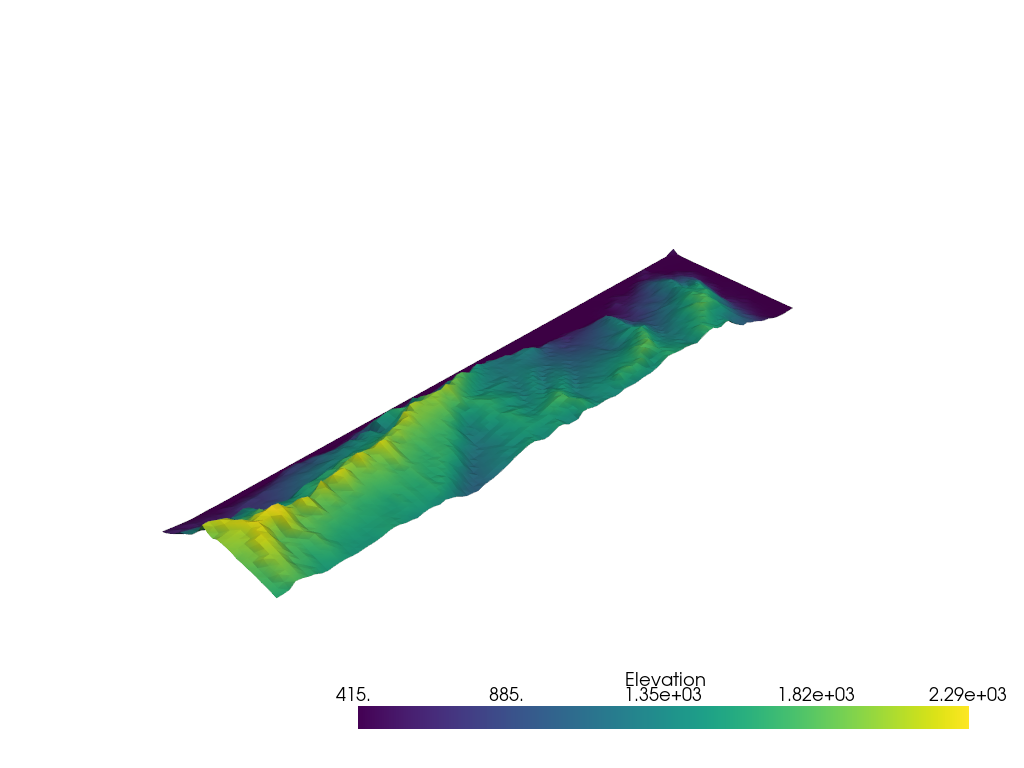

In [71]:
pl = pv.Plotter()
pl.add_mesh(mesh.elevation())
pl.show()

## Cutting surface

In [72]:
height = df.max().max()+1
zero = df.min().min()-1

In [73]:
points = []
for point in last_active_drawings["geometry"]["coordinates"][0]:
    point_lv03 = list(coords2LV03(lat=point[1], lng=point[0]))
    print(point, point_lv03)
    point_lv03.append(height)
    points.append(point_lv03)
poly = pv.lines_from_points(points)

[9.041576, 47.128432] [721614, 220958]
[9.041576, 47.171394] [721517, 225733]
[9.325848, 47.171394] [743063, 226213]
[9.325848, 47.128432] [743178, 221438]
[9.041576, 47.128432] [721614, 220958]


In [74]:
poly

PolyData,Information
N Cells,4
N Points,5
N Strips,0
X Bounds,"7.215e+05, 7.432e+05"
Y Bounds,"2.210e+05, 2.262e+05"
Z Bounds,"2.296e+03, 2.296e+03"
N Arrays,0


c:\Users\pasca\GIT\SwissContour\venv\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


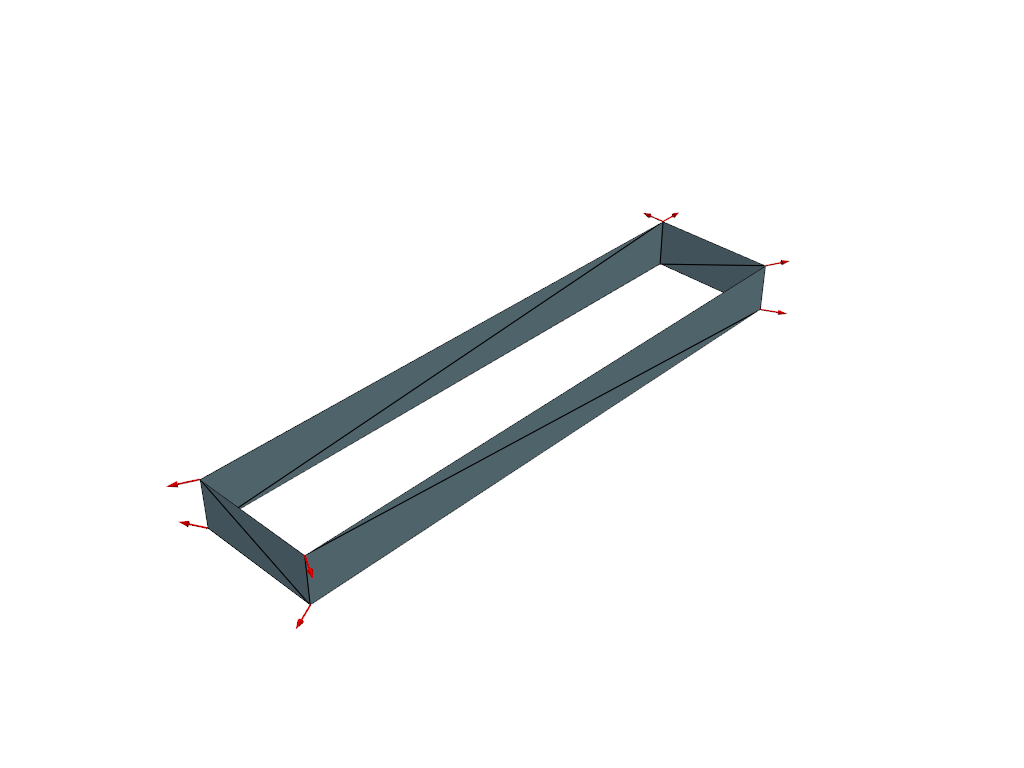

In [75]:
poly_3d = poly.extrude([0, 0, -(height - zero)], capping=False)
poly_3d.plot_normals(mag=1000, show_edges=True, color="red")

In [76]:
# Compute normals (by default, they are outward)
poly_3d.compute_normals(inplace=True)

# Check the normals' direction (optional)
outward_normals = poly_3d.point_normals

# If you find that the normals are pointing inward, flip them
if outward_normals[:, 1].mean() < 0:
    print("flip normals")
    points = []
    for point in last_active_drawings["geometry"]["coordinates"][0]:
        point_lv03 = list(coords2LV03(lat=point[1], lng=point[0]))
        print(point, point_lv03)
        point_lv03.append(zero)
        points.append(point_lv03)
    poly = pv.lines_from_points(points)
    poly_3d = poly.extrude([0, 0, height-zero], capping=False)

flip normals
[9.041576, 47.128432] [721614, 220958]
[9.041576, 47.171394] [721517, 225733]
[9.325848, 47.171394] [743063, 226213]
[9.325848, 47.128432] [743178, 221438]
[9.041576, 47.128432] [721614, 220958]


c:\Users\pasca\GIT\SwissContour\venv\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


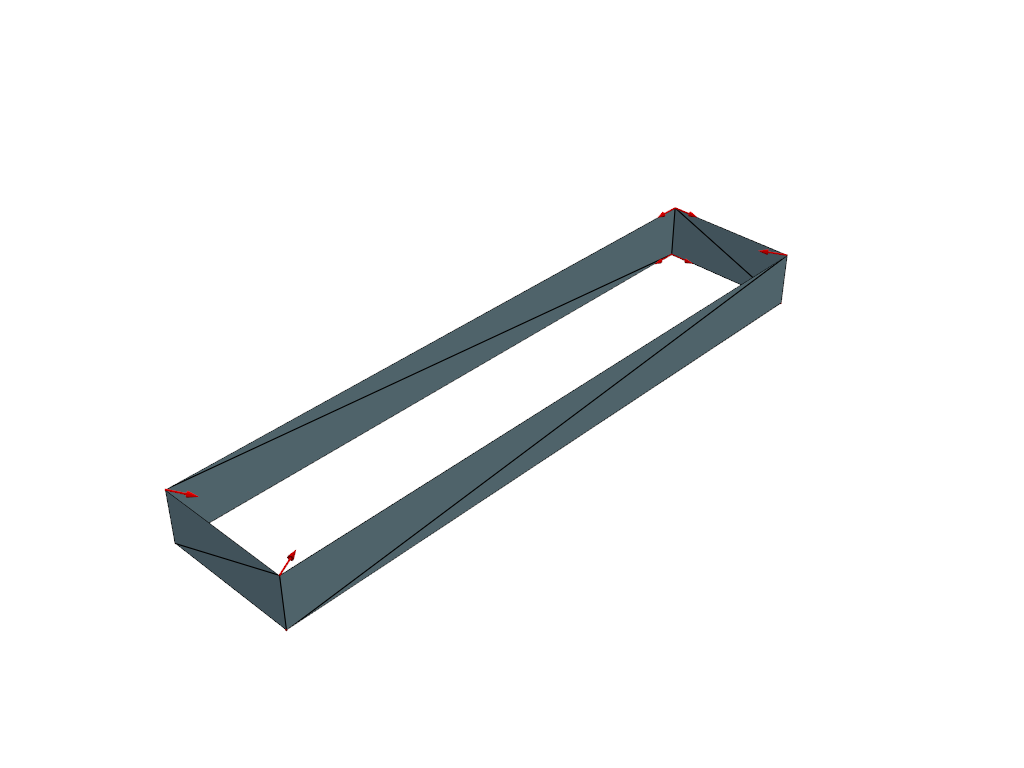

In [77]:
poly_3d.plot_normals(mag=1000, show_edges=True, color="red")

### with structured grid

In [78]:
mesh

StructuredGrid,Information
N Cells,2782
N Points,2916
X Bounds,"7.217e+05, 7.431e+05"
Y Bounds,"2.211e+05, 2.263e+05"
Z Bounds,"4.146e+02, 2.295e+03"
Dimensions,"27, 108, 1"
N Arrays,0


c:\Users\pasca\GIT\SwissContour\venv\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


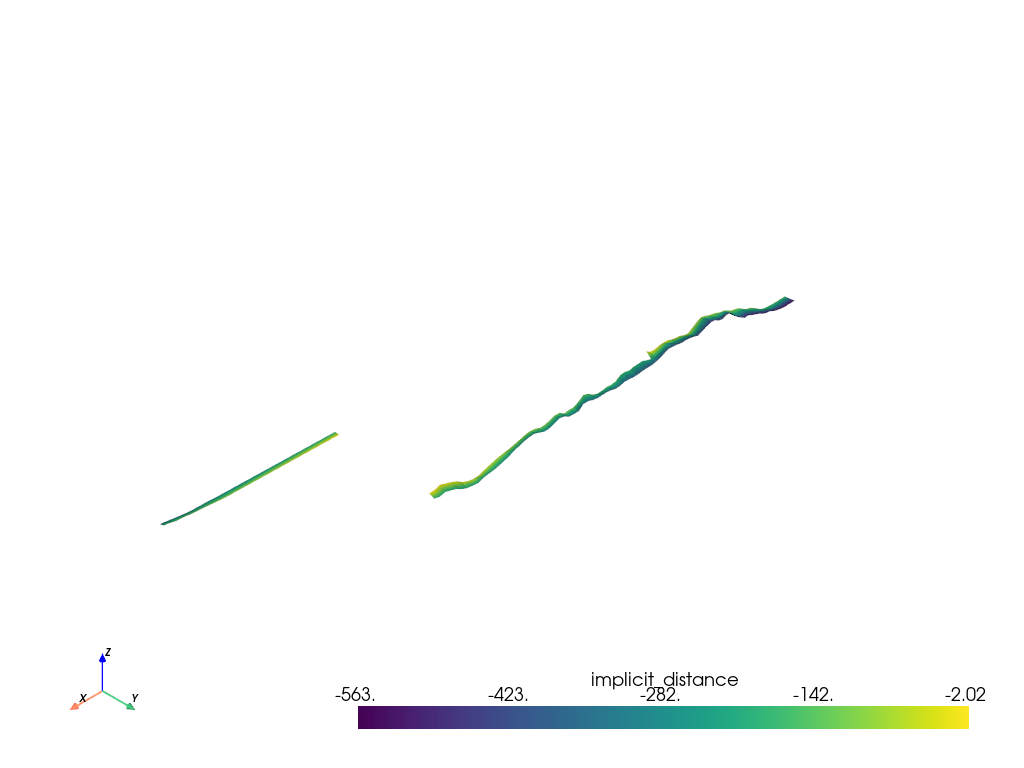

In [79]:
mesh.compute_implicit_distance(poly_3d, inplace=True)
inner = mesh.threshold(0.0, scalars="implicit_distance", invert=True)
inner.plot()

### with triangulate

In [80]:
mesh_tri = mesh.triangulate()
mesh_tri

UnstructuredGrid (0x214b4440280)
  N Cells:    5564
  N Points:   2916
  X Bounds:   7.217e+05, 7.431e+05
  Y Bounds:   2.211e+05, 2.263e+05
  Z Bounds:   4.146e+02, 2.295e+03
  N Arrays:   1

c:\Users\pasca\GIT\SwissContour\venv\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


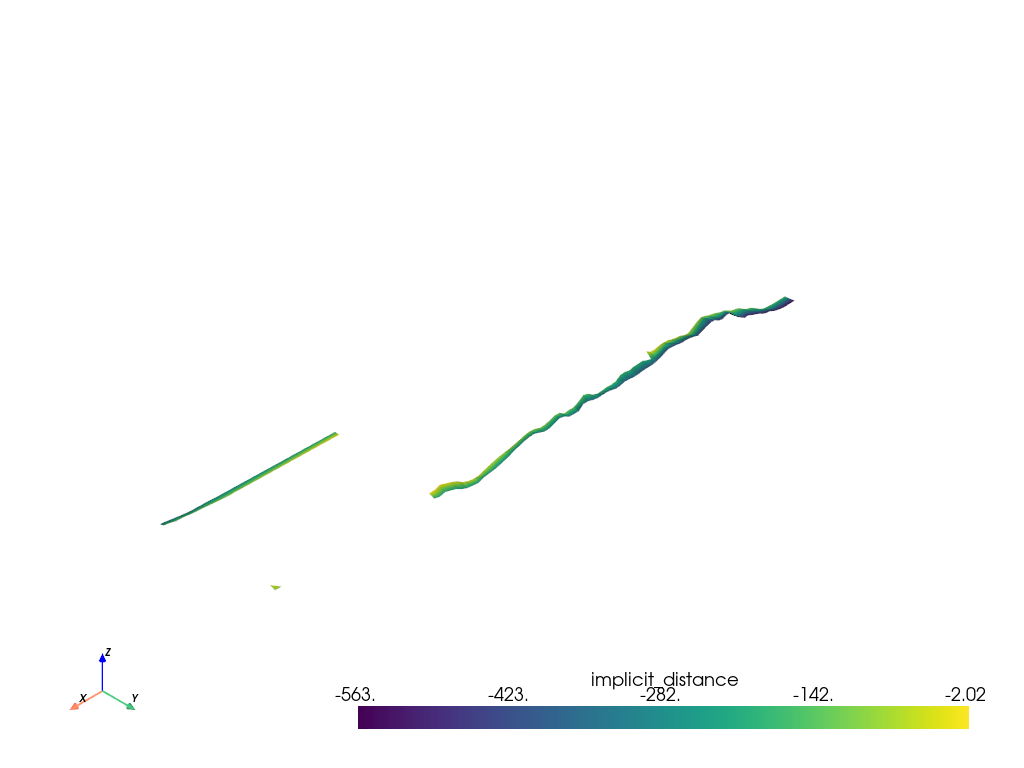

In [81]:
mesh_tri.compute_implicit_distance(poly_3d, inplace=True)
inner = mesh_tri.threshold(0.0, scalars="implicit_distance", invert=True)
inner.plot()

### with reconstruct surface from points

In [82]:
mesh_points = pv.wrap(mesh.points)
surf = mesh_points.reconstruct_surface()
surf

PolyData,Information
N Cells,2466
N Points,1313
N Strips,0
X Bounds,"7.209e+05, 7.433e+05"
Y Bounds,"2.203e+05, 2.265e+05"
Z Bounds,"-1.992e+02, 2.234e+03"
N Arrays,0


c:\Users\pasca\GIT\SwissContour\venv\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


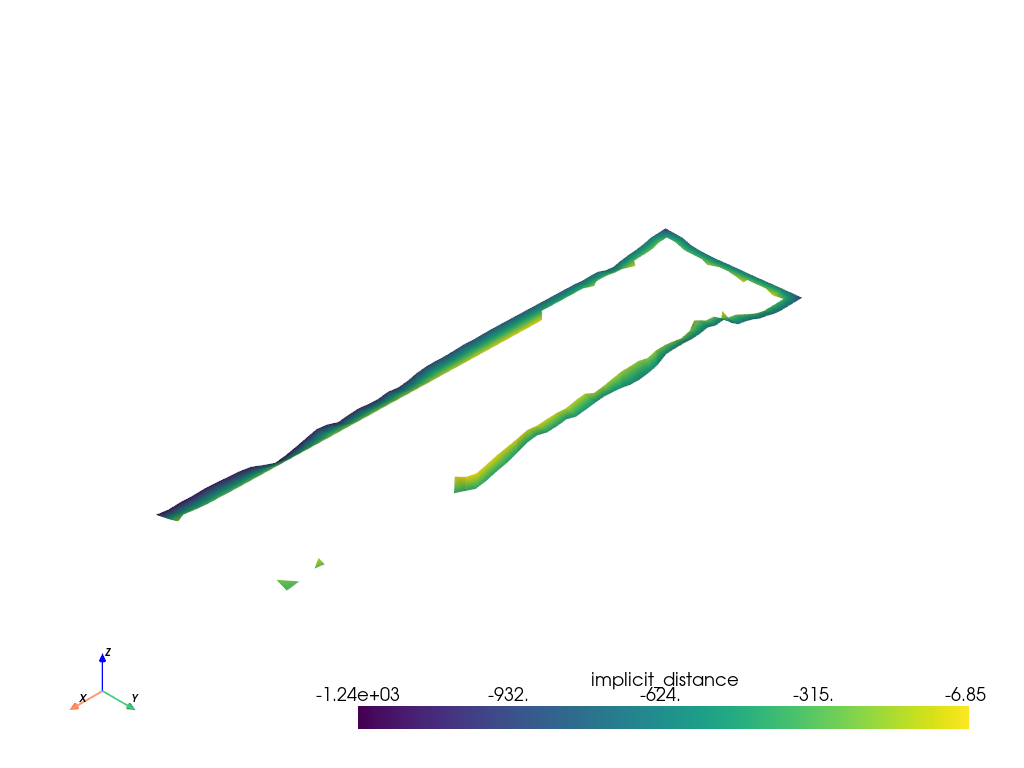

In [83]:
surf.compute_implicit_distance(poly_3d, inplace=True)
inner = surf.threshold(0.0, scalars="implicit_distance", invert=True)
inner.plot()

### BEST: first create 3D and then cut 

c:\Users\pasca\GIT\SwissContour\venv\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


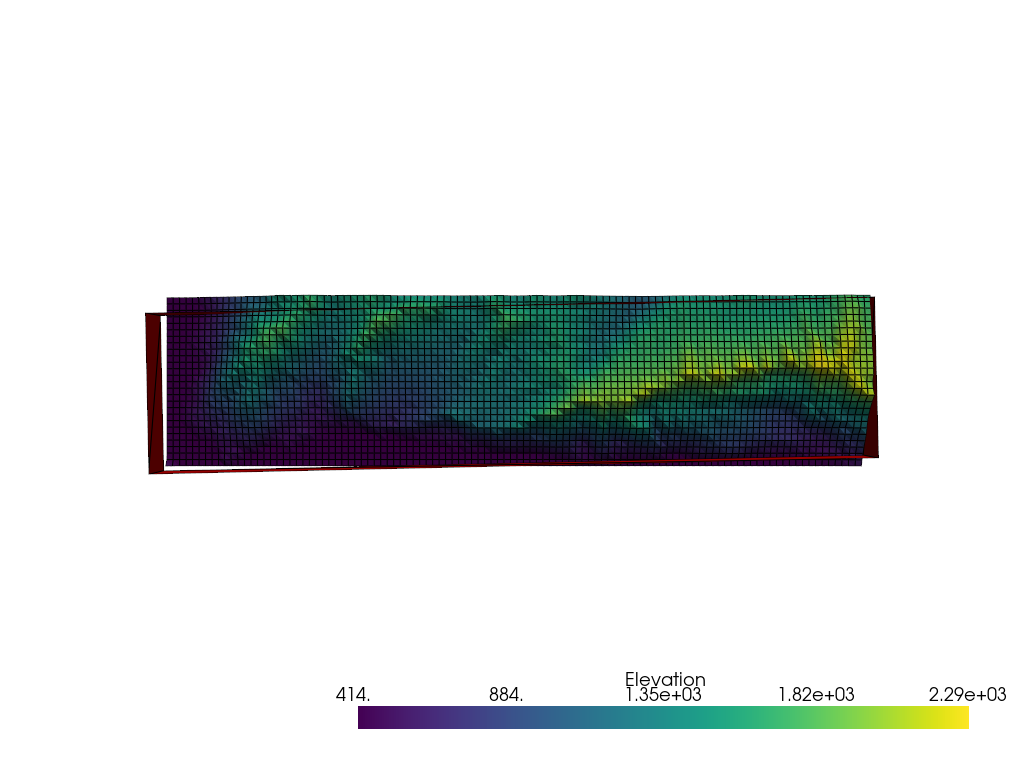

In [84]:
top = mesh.points.copy()
bottom = mesh.points.copy()
bottom[:, -1] = zero

model = pv.StructuredGrid()
model.points = np.vstack((top, bottom))
model.dimensions = [*mesh.dimensions[0:2], 2]
pl = pv.Plotter()
pl.add_mesh(model.elevation(), show_edges=True)
pl.add_mesh(poly_3d, show_edges=True, color="red")
pl.view_xy()
pl.show()

c:\Users\pasca\GIT\SwissContour\venv\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


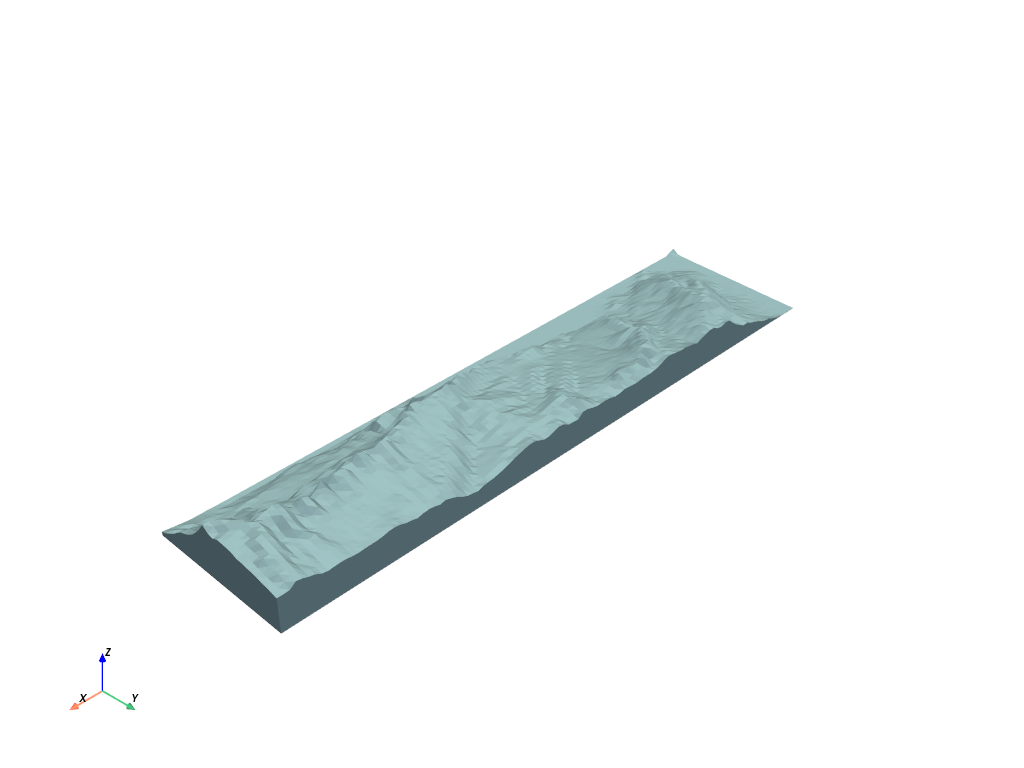

In [85]:
model.plot()

c:\Users\pasca\GIT\SwissContour\venv\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


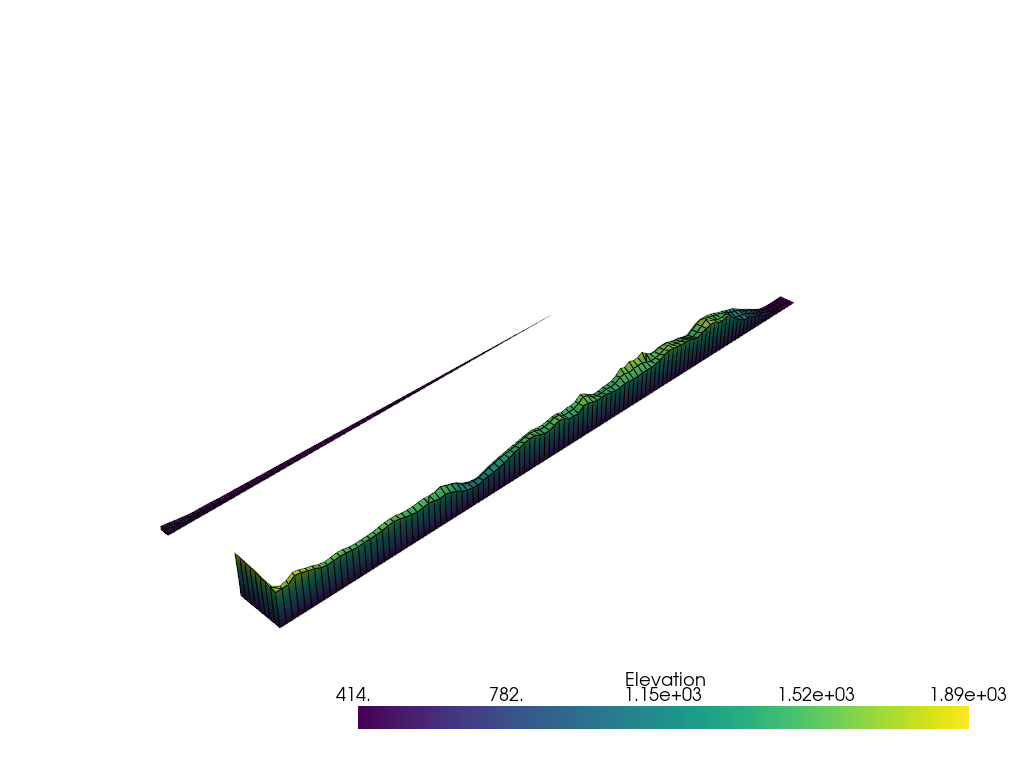

In [86]:
test = model.clip_surface(poly_3d)
pl = pv.Plotter()
pl.add_mesh(test.elevation(), show_edges=True)
pl.show()

## Smoothing

c:\Users\pasca\GIT\SwissContour\venv\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


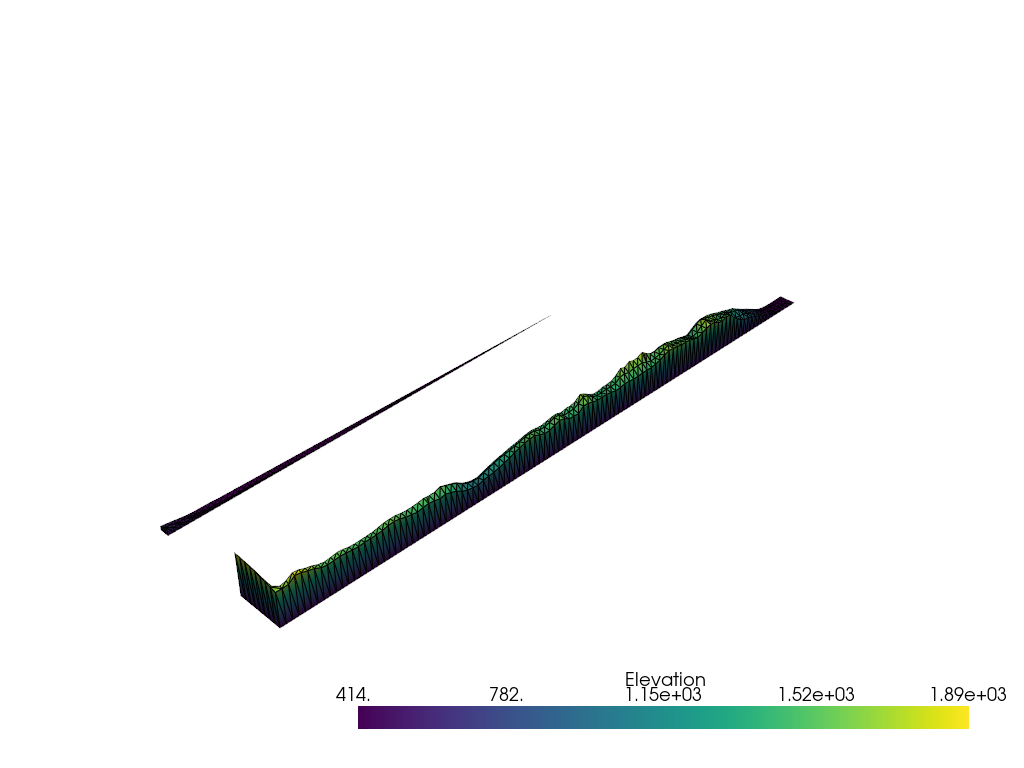

In [87]:
pl = pv.Plotter()
pl.add_mesh(test.triangulate().elevation(), show_edges=True)
pl.show()

## Save as stl

In [88]:
import vtk

output_name = "src/cache/test.stl"
surface_filter = vtk.vtkDataSetSurfaceFilter()
surface_filter.SetInputDataObject(test)

triangle_filter = vtk.vtkTriangleFilter()
triangle_filter.SetInputConnection(surface_filter.GetOutputPort())

writer = vtk.vtkSTLWriter()
writer.SetFileName(output_name)
writer.SetInputConnection(triangle_filter.GetOutputPort())
writer.Write()

1

# import DHM25

In [1]:
from src.web.data import *

In [2]:
df, meta = check_cache('dhm25')

dhm25
file not in cache... try to download
file downloaded
shape: (9121, 15401)
file structured


In [4]:
df

------------
## Create Surface

In [ ]:
x = np.ones(df.shape)
y = x.copy()

In [ ]:
x *= np.array(df.columns)
x

array([[479987.5, 480012.5, 480037.5, ..., 864937.5, 864962.5, 864987.5],
       [479987.5, 480012.5, 480037.5, ..., 864937.5, 864962.5, 864987.5],
       [479987.5, 480012.5, 480037.5, ..., 864937.5, 864962.5, 864987.5],
       ...,
       [479987.5, 480012.5, 480037.5, ..., 864937.5, 864962.5, 864987.5],
       [479987.5, 480012.5, 480037.5, ..., 864937.5, 864962.5, 864987.5],
       [479987.5, 480012.5, 480037.5, ..., 864937.5, 864962.5, 864987.5]])

In [ ]:
y = (y.T*np.array(df.index)).T
y

array([[301987.5, 301987.5, 301987.5, ..., 301987.5, 301987.5, 301987.5],
       [301962.5, 301962.5, 301962.5, ..., 301962.5, 301962.5, 301962.5],
       [301937.5, 301937.5, 301937.5, ..., 301937.5, 301937.5, 301937.5],
       ...,
       [ 74037.5,  74037.5,  74037.5, ...,  74037.5,  74037.5,  74037.5],
       [ 74012.5,  74012.5,  74012.5, ...,  74012.5,  74012.5,  74012.5],
       [ 73987.5,  73987.5,  73987.5, ...,  73987.5,  73987.5,  73987.5]])

In [ ]:
z = np.array(df)
z

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
grid = pv.StructuredGrid(x, y, z)
grid.save(filename="src/cache/DHM25.vtk", binary=True)

ERROR:root:Unable to open file: C:\Users\pasca\GIT\SwissContour\cache\DHM25.vtk


In [27]:
#grid.elevation().plot(scalars='Elevation', cmap='terrain', interpolate_before_map=False)

## create 3D

In [ ]:
#load from cache
struct = pv.read("cache/DHM25.vtk")

c:\Users\pasca\GIT\SwissContour\venv\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


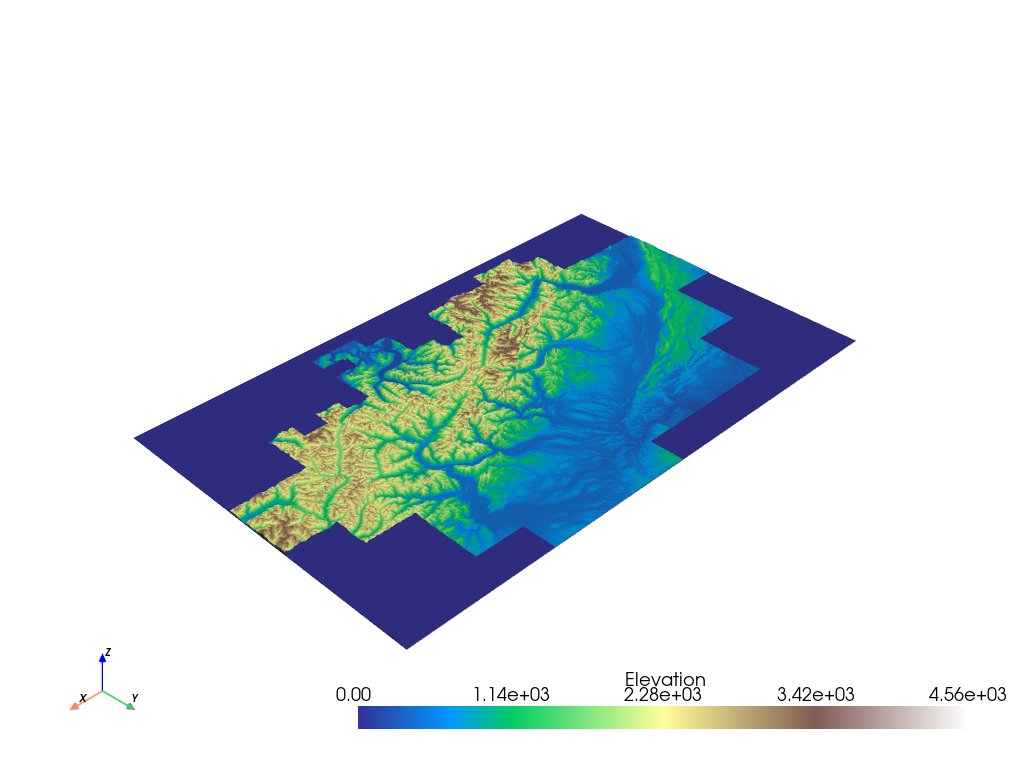

In [ ]:
top = struct.points.copy()
bottom = struct.points.copy()
bottom[:, -1] = 0  # Wherever you want the plane somehow nan should be excluded!

vol = pv.StructuredGrid()
vol.points = np.vstack((top, bottom))
vol.dimensions = [*struct.dimensions[0:2], 2]
#vol.elevation().plot(scalars='Elevation', cmap='terrain', interpolate_before_map=False)

-------

# Load Detail Data from API

In [ ]:
import pandas as pd
import requests, zipfile, io
import os

In [ ]:
urls = pd.read_csv("src/data/ch.swisstopo.swisstlm3d-B3y02fZf.csv", header=None)

In [ ]:
for url in urls.iloc[:,-1]:
    print(url)
    if not os.path.exists(r"A:\3D_swiss/"+url.split("/")[-1]):
        r = requests.get(url)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(r"A:\3D_swiss/"+url.split("/")[-1])

In [ ]:

for url in urls.iloc[:,-1]:
    print(url)
    response = requests.get(url, stream=True)
    with open("WDI_CSV.zip", mode="wb") as file:
        for chunk in response.iter_content(chunk_size=10 * 1024):
            file.write(chunk)

In [ ]:
for link in 


In [ ]:
async def download_file(url):
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as response:
            if "content-disposition" in response.headers:
                header = response.headers["content-disposition"]
                filename = header.split("filename=")[1]
            else:
                filename = url.split("/")[-1]
            with open(filename, mode="wb") as file:
                while True:
                    chunk = await response.content.read()
                    if not chunk:
                        break
                    file.write(chunk)
                print(f"Downloaded file {filename}")

In [ ]:
import geopandas as gpd
import pyogrio

def get_switzerland(**kwargs) -> gpd.GeoDataFrame:
    """get switzerland border from swisstopo (local loaded)
    """
    gdf = gpd.read_file("src/data/swissBOUNDARIES3D_1_4_TLM_LANDESGEBIET.shp", engine="pyogrio").to_crs(epsg=4326)
    return gdf[gdf["NAME"]=="Schweiz"]
get_switzerland()

# Load XYZ

In [ ]:
df = pd.read_csv("src/data/DHM200.xyz", delimiter=" ", header=None, dtype=float, names=["X","Y","Z"])
df["X"] -= df["X"].min()
df["Y"] -= df["Y"].min()

In [ ]:
df.to_numpy()

In [ ]:
points = pv.PolyData(df.to_numpy())
mesh = pv.PolyData(points)
elevated = mesh.elevation()
elevated.plot(scalars='Elevation', cmap='terrain', interpolate_before_map=False)

# UI
Get coords from map to know...
- which resolution of data is needed
- get data from database or swisstopo or cache
- cut from geopandas  

folium on streamlit (communicates)

In [ ]:
import pickle
import pandas

In [ ]:
with open('cache/modeldata200.pkl', 'rb') as f:
    model = pickle.load(f)

TypeError: Argument 'placement' has incorrect type (expected pandas._libs.internals.BlockPlacement, got slice)

In [ ]:
import folium
import streamlit as st
from folium.plugins import Draw

from streamlit_folium import st_folium
# https://folium.streamlit.app/limit_data_return

In [ ]:
m = folium.Map(
    location    = [39.949610, -75.150282],
    tiles="Stamen Terrain",
    zoom_start  = 5
    )
Draw(export=True).add_to(m)

c1, c2 = st.columns(2)
with c1:
    output = st_folium(m, width=700, height=500)

with c2:
    st.write(output)

In [ ]:
m

reduce number of Draw utilities

In [ ]:
import geojson
for sample in ["circle", "line", "marker", "point", "rectangle"]:
    with open("src/data/" + sample + ".geojson") as f:
        gj = geojson.load(f)
    print(sample)
    print(gj["features"][0]["geometry"])
    print(gj["features"][0]["geometry"]["coordinates"],"\n")